# Period detection in V and I bands


In this notebook I:
1. Make a stacked absolute value image to find variable sources
2. Use the aligned and subtracted images to measure changes in the flux on the detected variable sources
3. Make an score periodograms to find the periods and decide which detected sources are periodic (and have periods short enough for us to detect in this data)
4. Histogram the detected periods that pass our threshold

In [3]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator

from brokenaxes import brokenaxes

## Getting the list of files and seperating by waveband

In [4]:
sub_img_fles = glob("../data/NGC1866_images/*sub.fits")

In [5]:
sub_img_by_band = dict()

for fle in sub_img_fles:
    band = fits.getheader(fle)['FILTER']
    if not sub_img_by_band.get(band):
        sub_img_by_band[band] = [fle]
    sub_img_by_band[band].append(fle)

In [6]:
v_sub_fles = sub_img_by_band["V"]
#i_sub_fles = sub_img_by_band["I"]

In [7]:
i_sub_fles = glob("../data/NGC1866_images/*sub_new.fits")

In [8]:
len(v_sub_fles)

27

In [9]:
len(i_sub_fles)

24

## Stacking Images

On separate subtracted images, a star may be above or below the background
(which is zero).  Stacking these may add positive and negative fluxes, possibly
yielding something close to zero. Not very advantageous. The trick is to
transform each image so that every pixel is positive. Thus we take the absolute value
of the images before stacking. This will increase the detection ability, genuine
variable stars should stand out better.

Based on going through the images by eye looking for "good" subtraced images (as little "graininess" in the center of the cluster as possible, good FWHM, bright stars leaving as little residuals as possible) I am using the following images:
- V-band: 0,1,22,26
- I-band: 3,6,12,21

#### V-band

In [10]:
v_ccd_dataframes = [CCDData(np.abs(fits.getdata(v_sub_fles[x])), unit=u.dimensionless_unscaled) for x in [0,1,22,26]]
v_combiner = Combiner(v_ccd_dataframes)
v_combiner.data_arr.mask[np.isnan(v_combiner.data_arr)]=True
v_combined_average = v_combiner.average_combine()

In [12]:
hdu = fits.PrimaryHDU(v_combined_average)
hdu.writeto('../data/NGC1866_images/v_combined_difference.fits')

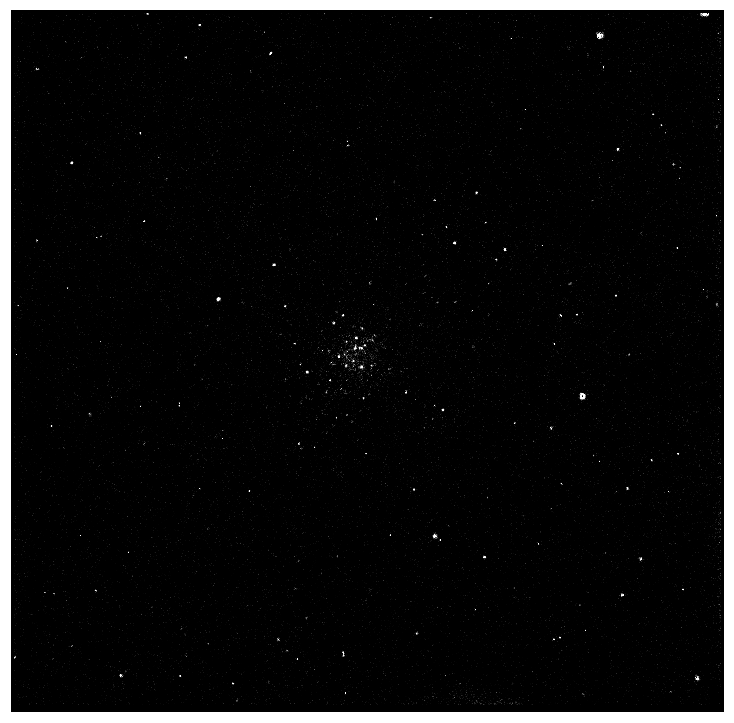

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(v_combined_average.data, cmap='gray',vmin=1,vmax=5)

fig.savefig("../doc/plots/v_difference_img.pdf")

#### I-band

In [13]:
i_ccd_dataframes = [CCDData(np.abs(fits.getdata(i_sub_fles[x])), unit=u.dimensionless_unscaled) for x in [2,5,10,21]]
i_combiner = Combiner(i_ccd_dataframes)
i_combiner.data_arr.mask[np.isnan(i_combiner.data_arr)]=True
i_combined_average = i_combiner.average_combine()

In [14]:
hdu = fits.PrimaryHDU(i_combined_average)
hdu.writeto('../data/NGC1866_images/i_combined_difference.fits')

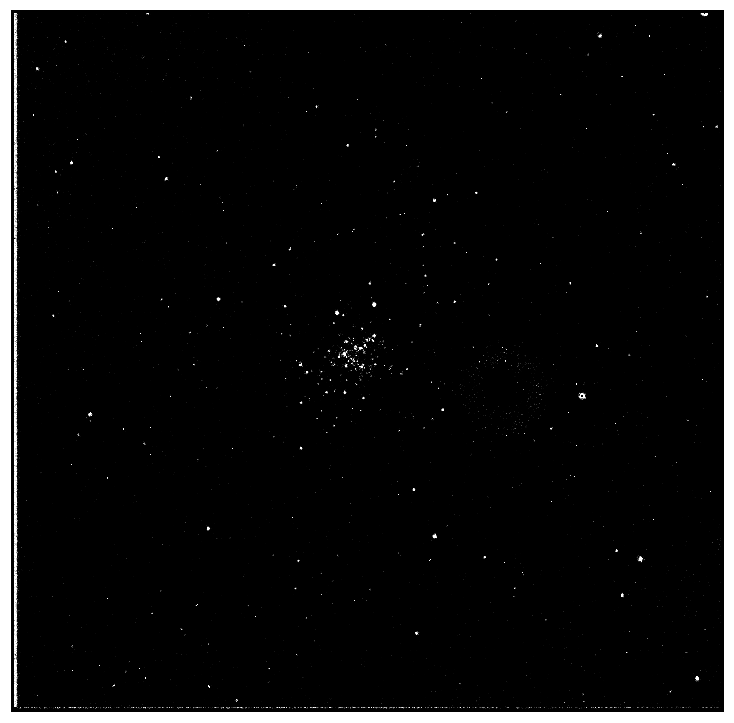

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(i_combined_average.data, cmap='gray',vmin=3,vmax=9)

fig.savefig("../doc/plots/i_difference_img.pdf")

## Finding sources in each image

I will use Daofind to make a catalog of sources for each image. At this stage I do not cross correlate with a lis of actual stars, but potentially I will want to cross correlate with both bands and the template to get a canoncial catalog.

Using ds9 and imexamin I determined that I should use a FWHM of 5 for the source detection.

#### V-band

In [11]:
v_img_mean, v_img_median, v_img_std = sigma_clipped_stats(v_combined_average.data, sigma=3.0, maxiters=5)

In [12]:
v_daofind = DAOStarFinder(fwhm=5, threshold=15*v_img_std)
v_img_catalog = v_daofind(v_combined_average.data - v_img_median)
print(len(v_img_catalog))

146


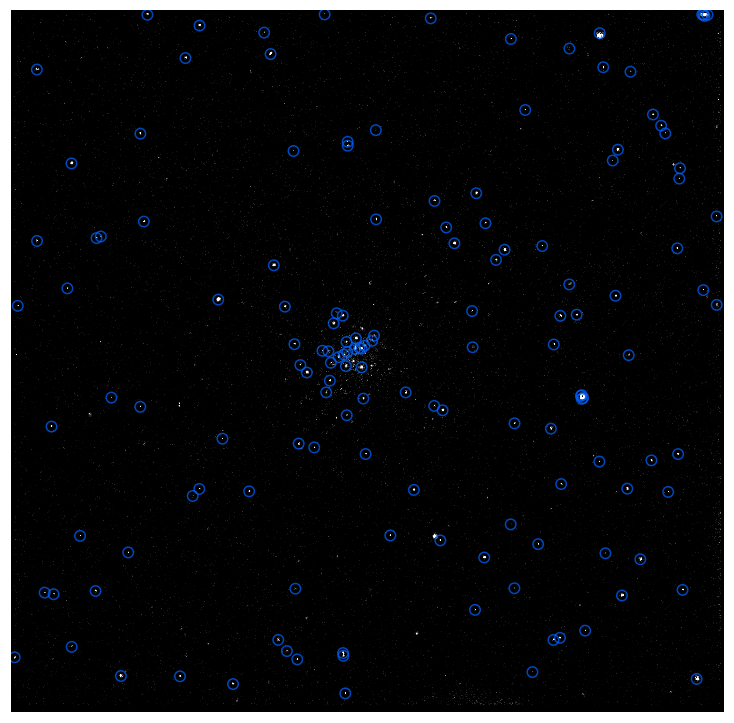

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(v_combined_average.data, cmap='gray',vmin=1,vmax=5)

positions = (v_img_catalog['xcentroid'], v_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#0061ff', lw=1.5, alpha=0.75)

plt.savefig("../doc/plots/stacked_img_with_detections_v.pdf")

#### I-band

In [13]:
i_img_mean, i_img_median, i_img_std = sigma_clipped_stats(i_combined_average.data, sigma=3.0, maxiters=5)

In [14]:
i_daofind = DAOStarFinder(fwhm=5, threshold=15*i_img_std)
i_img_catalog = i_daofind(i_combined_average.data - i_img_median)
print(len(i_img_catalog))

276


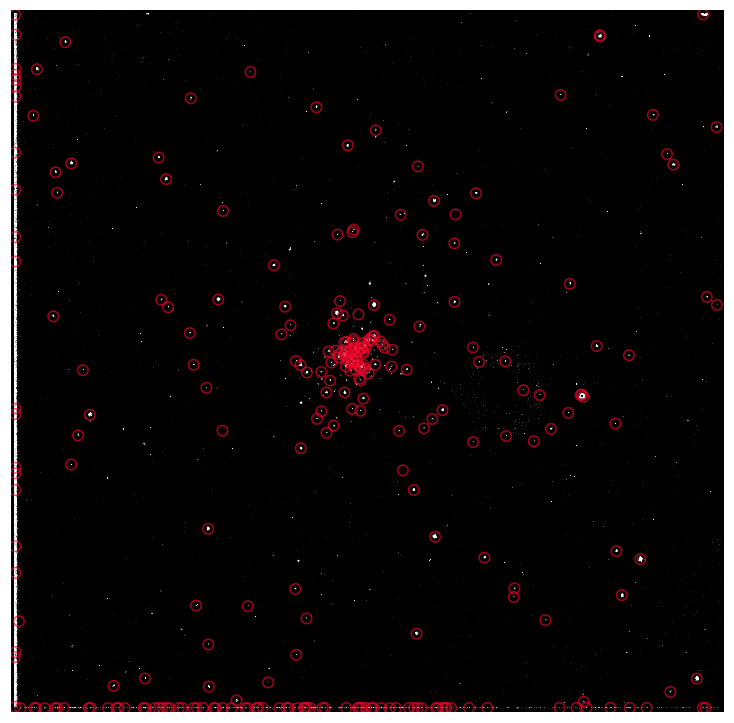

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(i_combined_average.data, cmap='gray',vmin=3,vmax=9)

positions = (i_img_catalog['xcentroid'], i_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#ff002b', lw=1.5, alpha=0.65)

plt.savefig("../doc/plots/stacked_img_with_detections_i.pdf")

#### Getting "canonical" sources from the v-template image

In [15]:
v_template_img = fits.getdata("../data/NGC1866_images/v_mean_template_crr.fits")

In [16]:
t_img_mean, t_img_median, t_img_std = sigma_clipped_stats(v_template_img, sigma=3.0, maxiters=5)

In [17]:
t_daofind = DAOStarFinder(fwhm=5, threshold=15*t_img_std)
t_img_catalog = t_daofind(v_template_img - t_img_median)
print(len(t_img_catalog))

1360


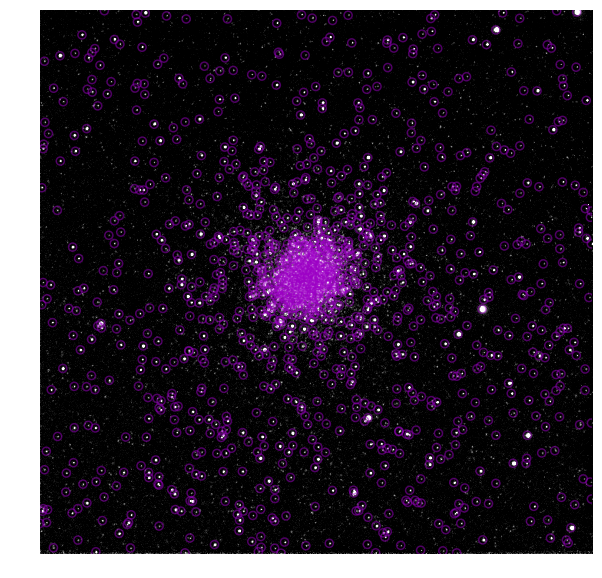

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('off')

ax.imshow(v_template_img, cmap='gray',vmin=3,vmax=15)

positions = (t_img_catalog['xcentroid'], t_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#9d00c6', lw=1.5, alpha=0.5)

Plotting all the images together, the white stars are variables as they appear in the i and v diff images and the template. The green come from the template.

In [18]:
rgb = np.dstack((i_combined_average.data/10,v_template_img/100,v_combined_average.data/10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


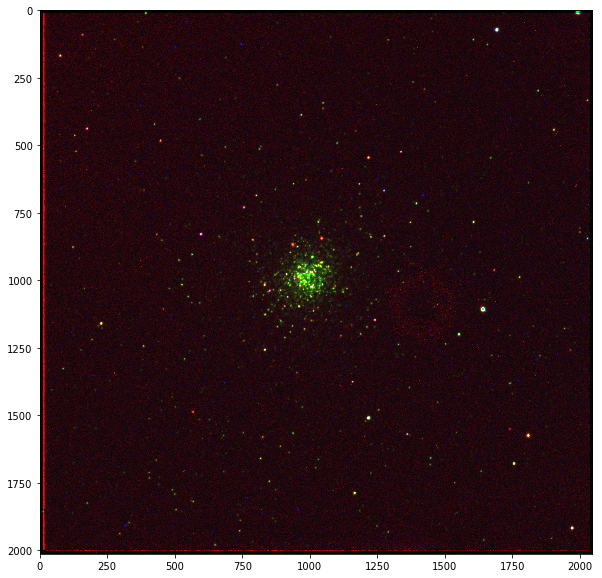

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(rgb)

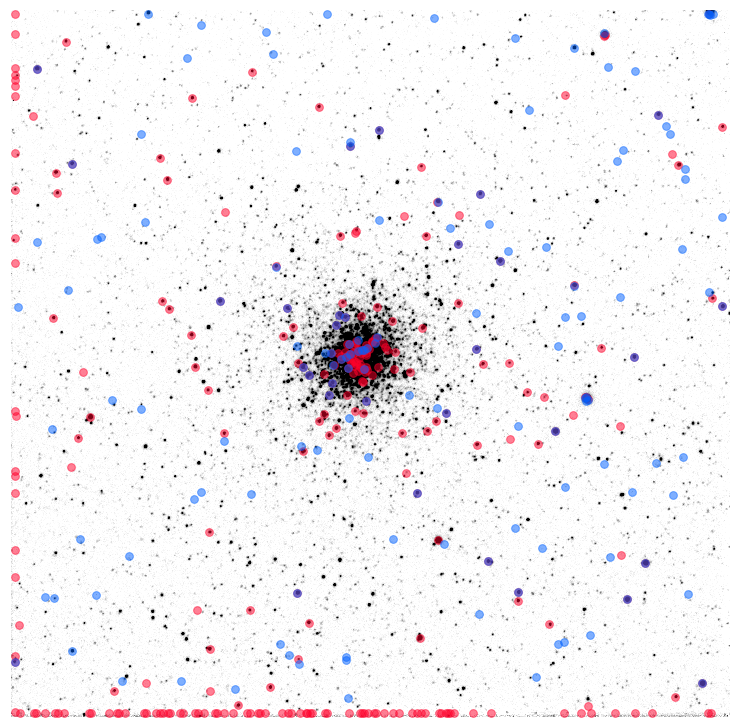

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)

#ax.scatter(t_img_catalog['xcentroid'], t_img_catalog['ycentroid'],
#           linestyle='None',marker='o',s=2,color='black')

ax.scatter(i_img_catalog['xcentroid'], i_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#ff002b')

ax.scatter(v_img_catalog['xcentroid'], v_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#0061ff')

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)

fig.tight_layout(pad=0)
fig.savefig("../doc/plots/detections_withfalsepos.pdf")

plt.show()

The purple splots with the black dots in the middle should be the true variables.

### Catalog matching

We'll need the template catalog, which will have far more stars, since it doesn't just include the variables. We will use the v_template for this, but we could use either.

In [19]:
v_wcs = WCS("../data/NGC1866_images/v_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(t_img_catalog['xcentroid'],t_img_catalog['ycentroid'],0)
t_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')
print(f"Number of stars in the template catalog: {len(t_img_catalog)}")

Number of stars in the template catalog: 1360


#### V band
Getting the catalog and performing the crossmatch

In [20]:
ras,decs = v_wcs.all_pix2world(v_img_catalog['xcentroid'],v_img_catalog['ycentroid'],0)
v_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [21]:
idx_v, d2d_v, d3d_v = v_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [22]:
v_crossmatch_table = Table(names=["x_v","y_v","t_id","v_dist"],
                           data=[v_img_catalog['xcentroid'].data, v_img_catalog['ycentroid'].data, idx_v, d2d_v])

In [23]:
mask = np.array([False]*len(v_crossmatch_table))

for t_id in np.unique(v_crossmatch_table['t_id']):
    if sum(v_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((v_crossmatch_table['t_id']==t_id) & 
             (v_crossmatch_table['v_dist'] != v_crossmatch_table[v_crossmatch_table['t_id']==t_id]['v_dist'].min()))

In [24]:
v_crossmatch_table = v_crossmatch_table[~mask]

#### I band
Getting the catalog and performing the crossmatch

In [25]:
i_wcs = WCS("../data/NGC1866_images/i_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(i_img_catalog['xcentroid'],i_img_catalog['ycentroid'],0)
i_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [26]:
idx_i, d2d_i, d3d_i = i_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [27]:
i_crossmatch_table = Table(names=["x_i","y_i","t_id","i_dist"],
                           data=[i_img_catalog['xcentroid'].data, i_img_catalog['ycentroid'].data, idx_i, d2d_i])

In [28]:
mask = np.array([False]*len(i_crossmatch_table))

for t_id in np.unique(i_crossmatch_table['t_id']):
    if sum(i_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((i_crossmatch_table['t_id']==t_id) & 
             (i_crossmatch_table['i_dist'] != i_crossmatch_table[i_crossmatch_table['t_id']==t_id]['i_dist'].min()))

In [29]:
i_crossmatch_table = i_crossmatch_table[~mask]

#### Putting together the full crossmatch table

In [30]:
full_crossmatch_table = join(v_crossmatch_table,i_crossmatch_table,"t_id")

In [31]:
full_crossmatch_table.add_column(Column(name="x_t",data=t_img_catalog['xcentroid'][full_crossmatch_table['t_id']]))
full_crossmatch_table.add_column(Column(name="y_t",data=t_img_catalog['ycentroid'][full_crossmatch_table['t_id']]))

Plotting the sources and removing the ones that are still bad.

In [32]:
mask = (full_crossmatch_table['v_dist'] < .0005) & (full_crossmatch_table['i_dist'] < .0005)

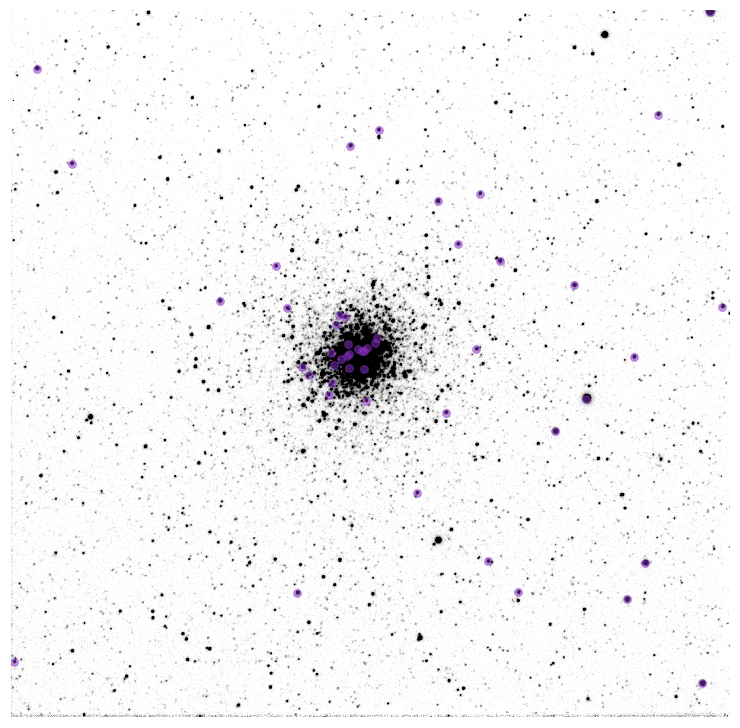

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)

ax.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#8932c8')

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)

fig.tight_layout(pad=0)
fig.savefig("../doc/plots/detections.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [33]:
full_crossmatch_table = full_crossmatch_table[mask]

In [34]:
print(f"Number of sources in both the I and V band difference images and the template image: {len(full_crossmatch_table)}")

Number of sources in both the I and V band difference images and the template image: 50


#### Plotting the sources on the template image

In [35]:
template_img = fits.getdata("../data/NGC1866_images/v_mean_template.fits")

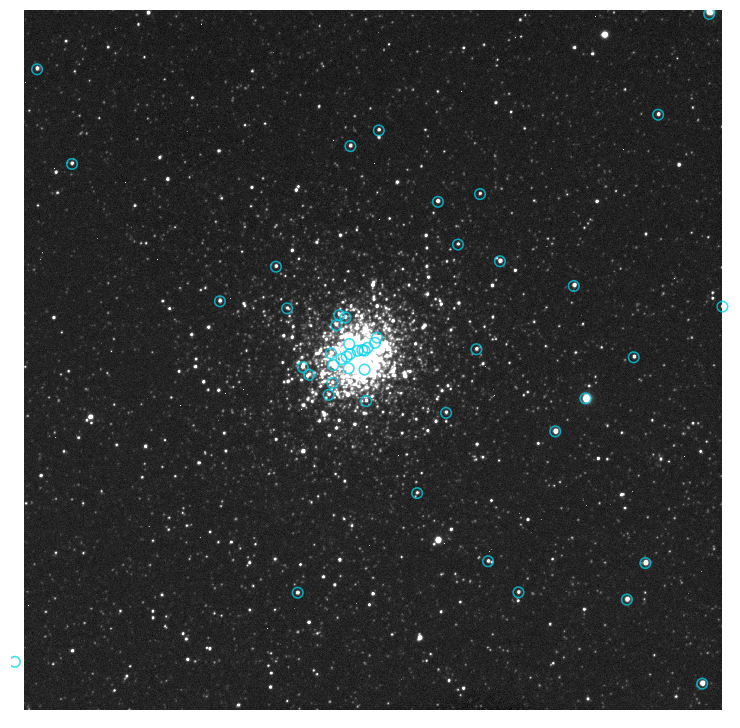

In [104]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())


#norm = LogNorm(vmin=0,vmax=80)
ax.imshow(template_img.data, cmap='gray',vmin=0,vmax=20)#, norm=norm)

positions_v = (full_crossmatch_table['x_v'], full_crossmatch_table['y_v'])
apertures_v = CircularAperture(positions_v, r=15.)
apertures_v.plot(color='#00d3ec', lw=1.5, alpha=0.5)

positions_i = (full_crossmatch_table['x_i'], full_crossmatch_table['y_i'])
apertures_i = CircularAperture(positions_v, r=15.)
apertures_i.plot(color='#00d3ec', lw=1.5, alpha=0.5)

fig.tight_layout(pad=0)

plt.savefig("../doc/plots/templat_with_detections.pdf")

Looking good!

### Photometry

Now we perform the photometry.

To better keep track of all the stars, adding an id column to the catalog.

In [36]:
full_crossmatch_table.add_column(Column(name="id",data=list(range(1,len(full_crossmatch_table)+1))))

In [37]:
full_crossmatch_table

<Table length=50>
       x_v                y_v          t_id ...        y_t           id 
                                            ...                         
     float64            float64       int64 ...      float64       int64
------------------ ------------------ ----- ... ------------------ -----
1986.6994706503272 11.152954686606513     2 ...  6.359598319211408     1
 74.56047701407032 168.92375557427164    46 ... 168.15662318603742     2
1841.5295567820388  297.9900980067216    88 ... 298.19249055423774     3
1046.7282707054287  342.7908715932275   101 ... 342.78812419131907     4
 966.0289983819378 387.35990736731895   110 ...  387.4582292786057     5
173.85442703798793  438.2017229525348   122 ...  438.0435544687341     6
1334.7700185481513  523.6909357594617   152 ...  523.8486397894245     7
 1215.011983688016  545.8138552195411   158 ...  545.4113619382455     8
 1271.979683036685  667.3597756463155   216 ...  667.3212027608911     9
               ...                ...   ... ...                ...   ...
1238.2038798668525 1146.2787941320523   939 ... 1145.9462167290642    41
1548.8513311778702 1199.0817819083627   982 ... 1199.3464643302268    42
 1155.795306537801 1374.6683442284857  1083 ... 1374.7441369013318    43
1357.6078429575066  1568.528105159527  1182 ...  1568.812641353814    44
1805.3192872470313 1573.7536680826986  1186 ... 1573.6975051072507    45
1444.1738024912136  1656.780971352622  1219 ... 1657.0455322993623    46
 815.9303552778558  1657.971732409373  1220 ... 1658.6087894796513    47
1752.5569113226256 1677.5274583552725  1226 ... 1677.2338047261385    48
11.037858155514689 1854.7040259390656  1301 ... 1854.6407479037787    49
 1966.872921006733  1916.735746901053  1327 ... 1916.2744114196773    50

#### V-band

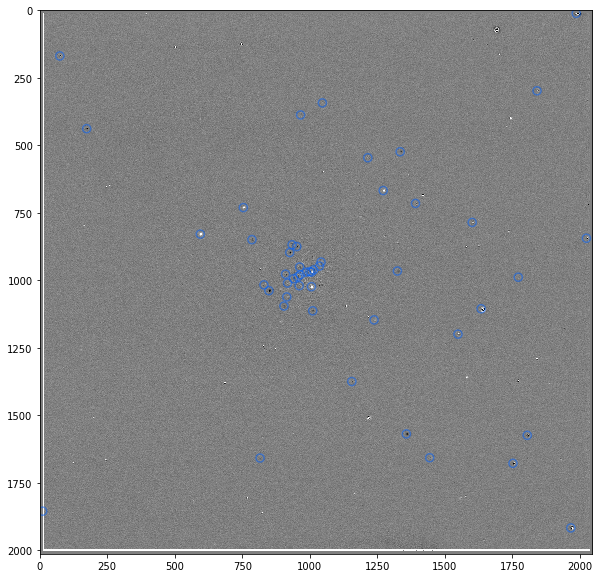

In [51]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(v_sub_fles[0])

ax.imshow(img, cmap='gray',vmin=-10,vmax=10)

positions_v = (full_crossmatch_table['x_v'], full_crossmatch_table['y_v'])
apertures_v = CircularAperture(positions_v, r=15.)
apertures_v.plot(color='#0061ff', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/subtracted_img_with_detections_v.pdf")

In [38]:
positions_v = [(x['x_v'], x['y_v']) for x in full_crossmatch_table]
apertures_v = CircularAperture(positions_v, r=6)

In [74]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in v_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_v, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum']*header['GAIN']/header['EXPTIME'])
        errs[star['id']].append(star['aperture_sum_err']*header['GAIN']/header['EXPTIME'])

In [75]:
lc_table_v = Table(names=["filename","date_obs"], data=[v_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_v.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_v.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [76]:
for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_v[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 2
14: 6
49: 15


In [77]:
lc_table_v.sort("date_obs")

#### Saving the V-band light curve table

In [114]:
lc_table_v.write("Vband_variable_lightcurve_table.ecsv",format='ascii.ecsv',overwrite=True)

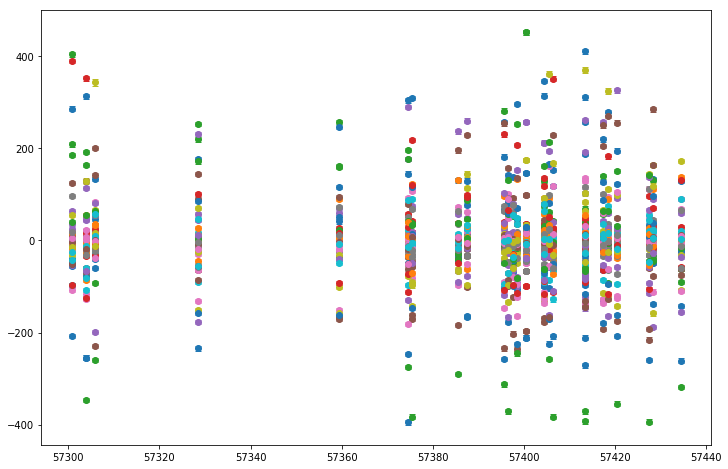

In [78]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_v['date_obs'],lc_table_v[f'mag_{i}'],yerr=lc_table_v[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    
#plt.savefig("../doc/plots/all_lcs.pdf")

#### I-band

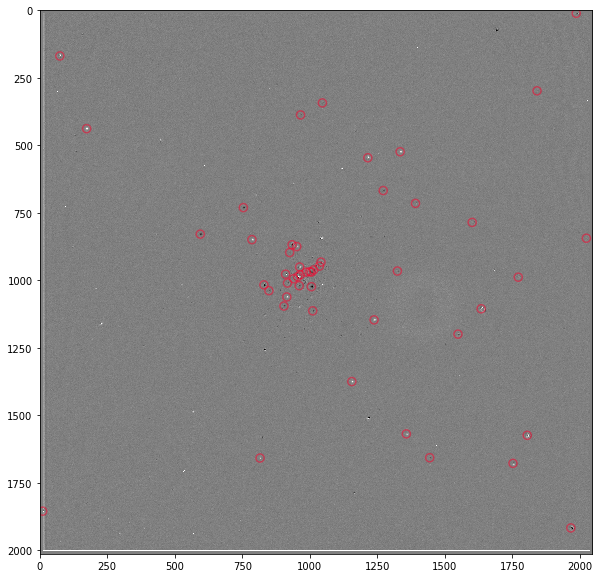

In [60]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(i_sub_fles[2])

ax.imshow(img, cmap='gray',vmin=-40,vmax=40)

positions_i = (full_crossmatch_table['x_i'], full_crossmatch_table['y_i'])
apertures_i = CircularAperture(positions_v, r=15.)
apertures_i.plot(color='#ff002b', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/subtracted_img_with_detections_i.pdf")

In [79]:
positions_i = [(x['x_i'], x['y_i']) for x in full_crossmatch_table]
apertures_i = CircularAperture(positions_i, r=6)

In [80]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in i_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_i, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum']*header['GAIN']/header['EXPTIME'])
        errs[star['id']].append(star['aperture_sum_err']*header['GAIN']/header['EXPTIME'])

In [81]:
lc_table_i = Table(names=["filename","date_obs"], data=[i_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_i.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_i.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [82]:
for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_i[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 1
14: 2
49: 11


In [83]:
lc_table_i.sort("date_obs")

#### Saving the I-band light curve table

In [115]:
lc_table_i.write("Iband_variable_lightcurve_table.ecsv",format='ascii.ecsv', overwrite=True)

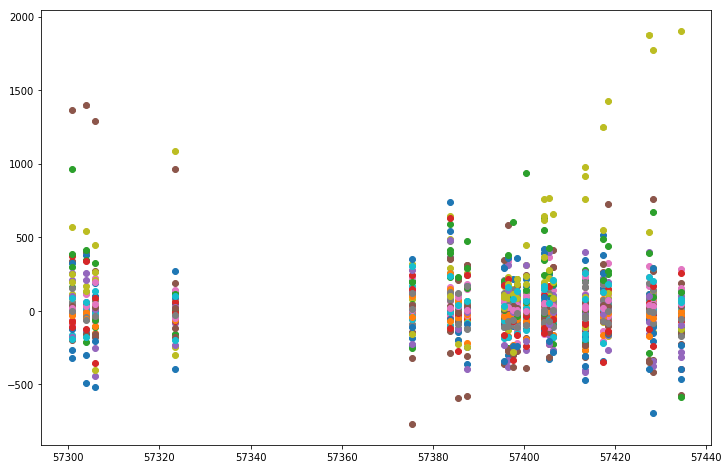

In [84]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_i['date_obs'],lc_table_i[f'mag_{i}'],yerr=lc_table_i[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    
#plt.savefig("../doc/plots/all_lcs.pdf")

## Period finding

### The functions we need

In [85]:
def score_period(times, mags, period, hist_size=8, uselog=False, verbose=False):
    """
    Given a period score how good a fit it is.
    Uses the same algorithm as the VARTOOLS Light Curve Analysis Program.  
    """
    
    # initialize the histograms 
    histN = np.zeros(hist_size)
    histA = np.zeros(hist_size)
    histB = np.zeros(hist_size)
    histC = np.zeros(hist_size)
    histD = np.zeros(hist_size)
    histE = np.zeros(hist_size)
    
    for i in range(len(times)):
        if np.isnan(mags[i]):
            continue
            
        X = np.fmod(times[i], period) / period
        index = int(hist_size * X)
        Y = mags[i]
        
        histN[index] += 1
        histA[index] += X
        histB[index] += X * X
        histC[index] += X * Y
        histD[index] += Y
        histE[index] += Y * Y

    sums = 0
    s1 = 0
    L2 = 0
    
    for i in range(hist_size):
        N = histN[i];
        
        if (N <= 1):
            if verbose:
                print("None enough mags in bin.")
            return(100000.0) # Error score, assumed to be bigger than a valid score
        
        Y = histD[i];
        X = Y * Y / N;
        
        # Checking on the denominator
        if ((N*(np.square(histA[i]) - (histB[i]*N)))) == 0:
            #(X + X)^2 - 2*(X^2 + X^2) 
            #print(np.square(histA[i]))
            #print(histB[i]*N)
            #print(histC[i])
            #print(histD[i])
            #print(histE[i])
            #print(histN[i])
            #print()
            continue
        sums += Y
        s1 += X 
        L2 += (np.square((histC[i]*N) - (Y*histA[i])) / (N*(np.square(histA[i]) - (histB[i]*N)))) + histE[i] - X
    
    s1 -= sums * sums / len(times)
    L2 /= len(times) - hist_size
    
    if ((s1 <= 0) or (L2 <= 0)):
        if verbose:
            print("Negative s1 or L2")
        return(100000.0) # Error score, assumed to be bigger than a valid score
    elif(uselog):
        return(np.log(L2 / s1))
    else:
        return(-s1/L2)

In [88]:
def find_best_period(times, mags, errs, clip_sigma=3, peak_height=None, plots=True, outfile=None, verbose=False):
    
    # Getting rid of the nans
    times = times[~np.isnan(mags)]
    errs = errs[~np.isnan(mags)]
    mags = mags[~np.isnan(mags)]
    
    # Getting rid of outliers
    #clipped_mags = sigma_clip(mags, sigma=clip_sigma, maxiters=1)
    #times = times[~clipped_mags.mask]
    #errs = errs[~clipped_mags.mask]
    #mags = mags[~clipped_mags.mask]

    # Doing the periodogram
    lomb = LombScargle(times,mags)
    frequency = np.linspace(0,2,2680)
    frequency = frequency[1:] # need to get rid of the literal 0 point
    power = lomb.power(frequency)
    
    #frequency, power = lomb.autopower()
    
    if plots:
        fig = plt.figure(figsize=(10,8))
        ax1 = fig.add_subplot(211)
        ax1.plot(frequency, power)
        ax1.set_xlabel("frequency")
        ax1.set_ylabel("power")
        
    # Finding the peaks 
    peak_inds, _ = find_peaks(power,height=peak_height)
    peak_pds = 1/frequency[peak_inds]#.value
    
    min_score = 100000
    min_score_pd = 0
    for period in peak_pds:
        score = score_period(times, mags, period, hist_size=5, uselog=True, verbose=False)
        if score < min_score:
            min_score = score
            min_score_pd = period
            
    if verbose:
        print(f"Best score: {min_score}")
        print(f"Best period: {min_score_pd} days")
          
    if plots:
        ax2 = fig.add_subplot(212)
        ax2.errorbar(times%min_score_pd, mags, yerr=errs,
                     marker='o',linestyle='None',capsize=3)
        ax2.set_xlabel("phase (days)")
        ax2.set_ylabel("flux")
        
        if outfile:
            plt.savefig(outfile)
        
        plt.show()  
        
    return min_score_pd, min_score

### Running the period finding

#### V-band

In [86]:
full_crossmatch_table.add_column(Column(name="period_v",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_v",dtype=float,length=len(full_crossmatch_table)))

In [89]:
for star in full_crossmatch_table:
    #print(star['id'])
    period,score = find_best_period(lc_table_v['date_obs'], lc_table_v[f'mag_{star["id"]}'], 
                                    lc_table_v[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    peak_height=0.3, plots=False)
    #print(period,score)
    #print()
    #print()
    
    
    star['period_v'] = period
    star['score_v'] = score

#### I-band

In [90]:
full_crossmatch_table.add_column(Column(name="period_i",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_i",dtype=float,length=len(full_crossmatch_table)))

In [91]:
for star in full_crossmatch_table:
    period,score = find_best_period(lc_table_i['date_obs'], lc_table_i[f'mag_{star["id"]}'], 
                                    lc_table_i[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    plots=False)
    star['period_i'] = period
    star['score_i'] = score

### Comparing the bands and finding good cutoffs

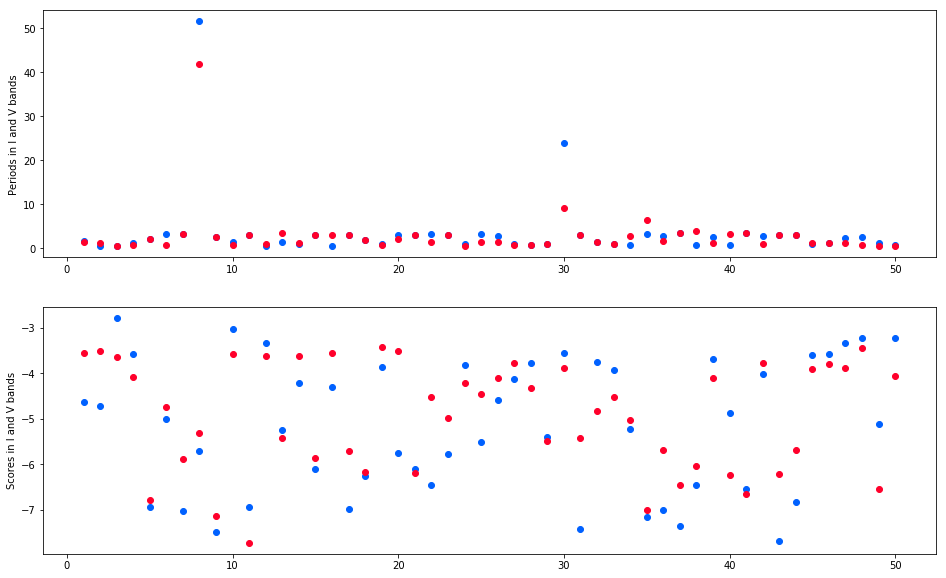

In [92]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
ax1.plot(full_crossmatch_table['id'],full_crossmatch_table['period_v'],'o',color='#0061ff')
ax1.plot(full_crossmatch_table['id'],full_crossmatch_table['period_i'],'o',color='#ff002b')
ax1.set_ylabel("Periods in I and V bands")

ax2 = fig.add_subplot(212)
ax2.plot(full_crossmatch_table['id'],full_crossmatch_table['score_v'],'o',color='#0061ff')
ax2.plot(full_crossmatch_table['id'],full_crossmatch_table['score_i'],'o',color='#ff002b')
ax2.set_ylabel("Scores in I and V bands")
plt.show()

#### Choosing whichever period had the best score as the "true" period

In [93]:
full_crossmatch_table.add_column(Column(name="period_best",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_best",dtype=float,length=len(full_crossmatch_table)))
for star in full_crossmatch_table:
    if star["score_v"] < star["score_i"]: # V period is better
        star["period_best"] = star["period_v"]
        star["score_best"] = star["score_v"]
    else:
        star["period_best"] = star["period_i"]
        star["score_best"] = star["score_i"]

#### Saving the full crossmatch table

In [116]:
full_crossmatch_table.write("variable_star_parameter_table.ecsv",format="ascii.ecsv", overwrite=True)

#### Making a mask to apply a score threshold

Basically by looking at the light curves by eye and knowing about how many we are looking for in the cluster, arrived at -5 as a good threshold.

In [94]:
mask = (full_crossmatch_table["score_best"] < -5)# & (full_crossmatch_table["period_best"] < 20)
sum(mask)

27

In [95]:
def plot_periodic(lc_table_v, lc_table_i, star_row, save=False):
    
    idx = star_row["id"]
    v_pd = star_row["period_v"]
    i_pd = star_row["period_i"]
    
    fig = plt.figure(figsize=(12,8))
    
    ax1 = fig.add_subplot(211)
    ax1.errorbar(lc_table_v['date_obs']%v_pd, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#0061ff', label=f"V band")
    ax1.errorbar(lc_table_i['date_obs']%v_pd, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#ff002b', label=f"I band")
    ax1.set_title(f"V-Band Period: {v_pd:.4}, score: {star_row['score_v']:.4}")
    ax1.set_xlabel("phase (days)")
    ax1.set_ylabel("flux")
    ax1.legend()
    
    ax2 = fig.add_subplot(212, sharex = ax1)
    ax2.errorbar(lc_table_v['date_obs']%i_pd, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#0061ff', label=f"V band")
    ax2.errorbar(lc_table_i['date_obs']%i_pd, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#ff002b', label=f"I band")
    ax2.set_title(f"I-Band Period: {i_pd:.4}, score: {star_row['score_i']:.4}")
    ax2.set_xlabel("phase (days)")
    ax2.set_ylabel("flux")
    ax2.legend()    

    plt.tight_layout()
        
    if save:
        plt.savefig(f"../doc/plots/phased_lc_{idx}.pdf")
        
    plt.show()  
    

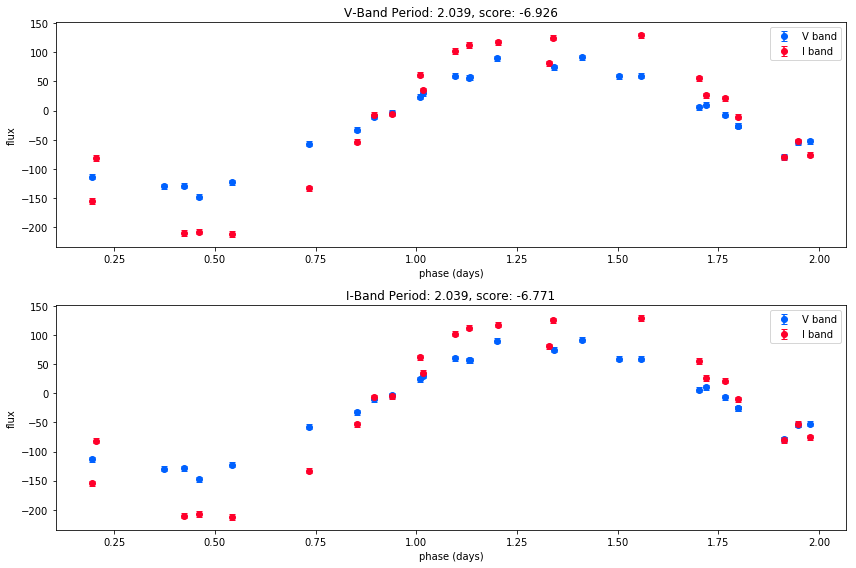

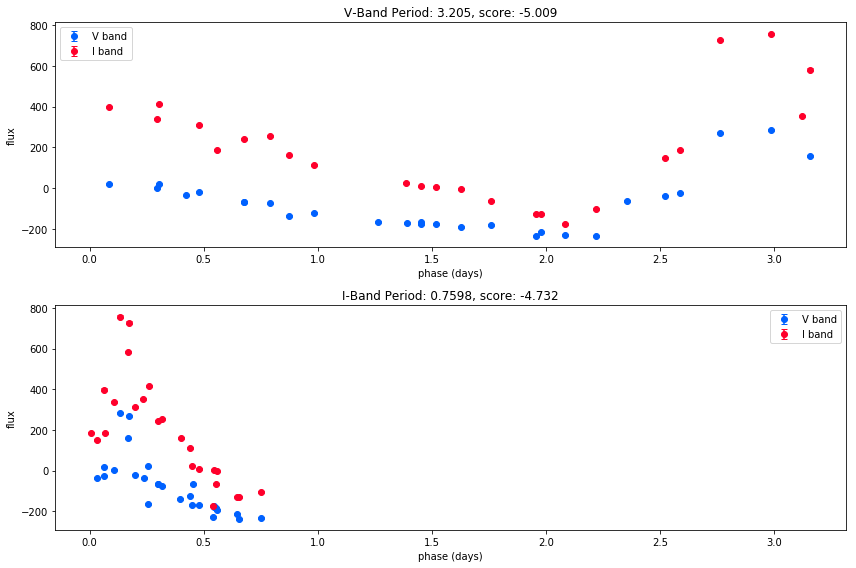

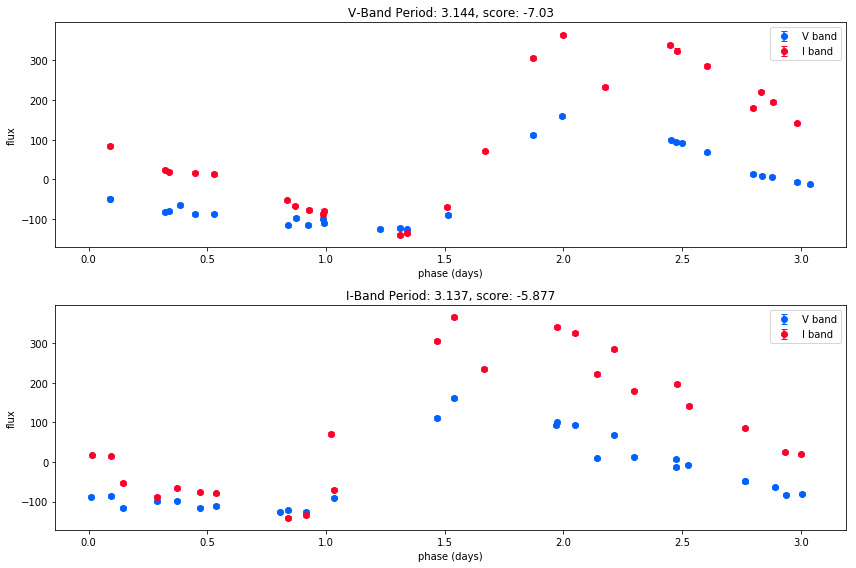

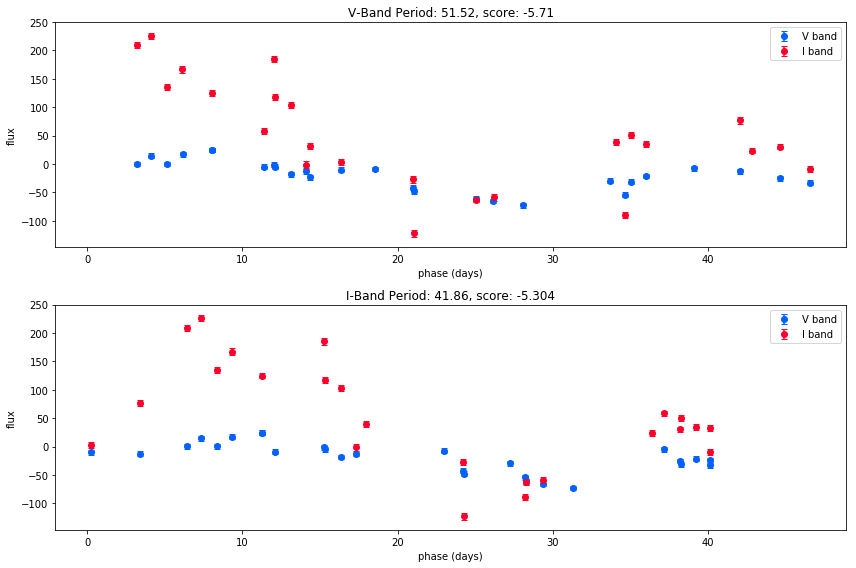

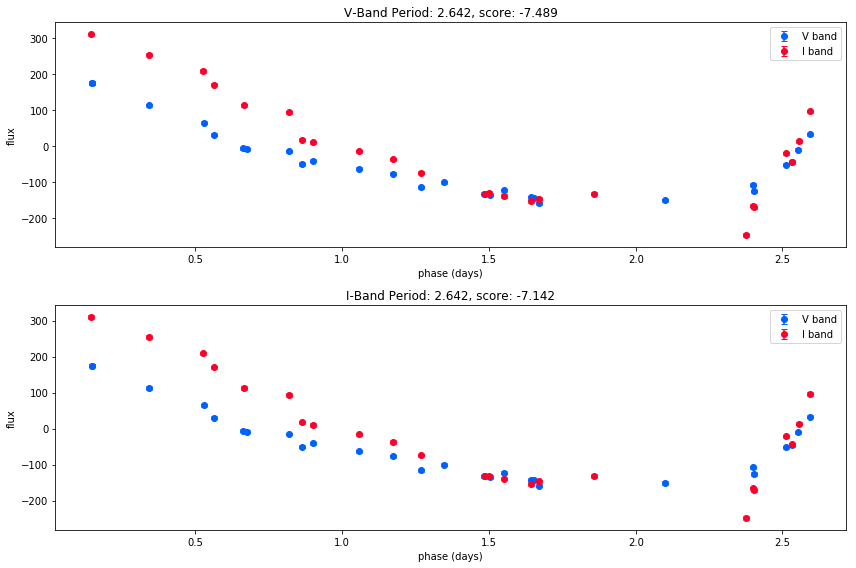

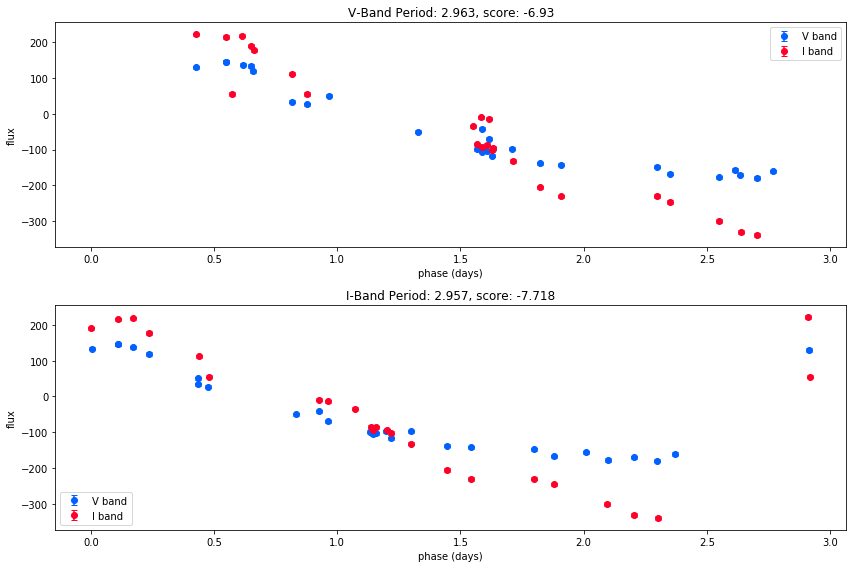

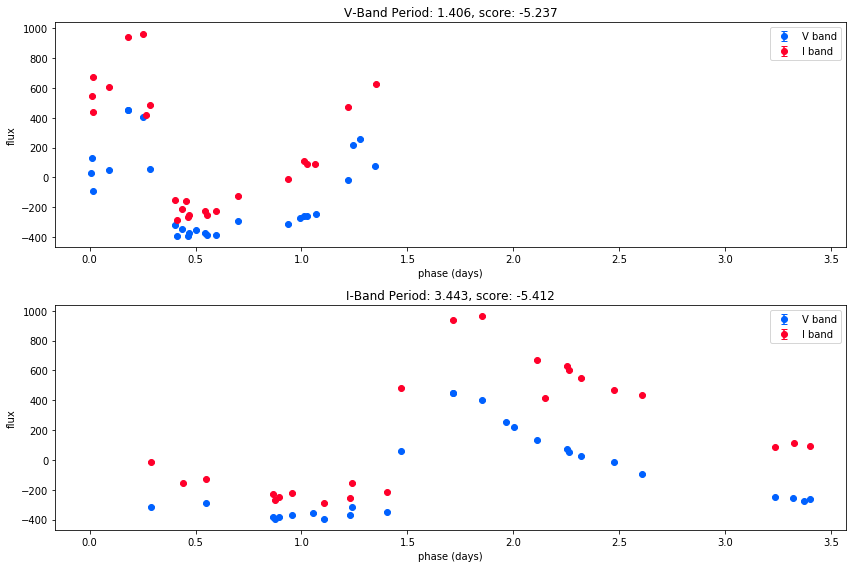

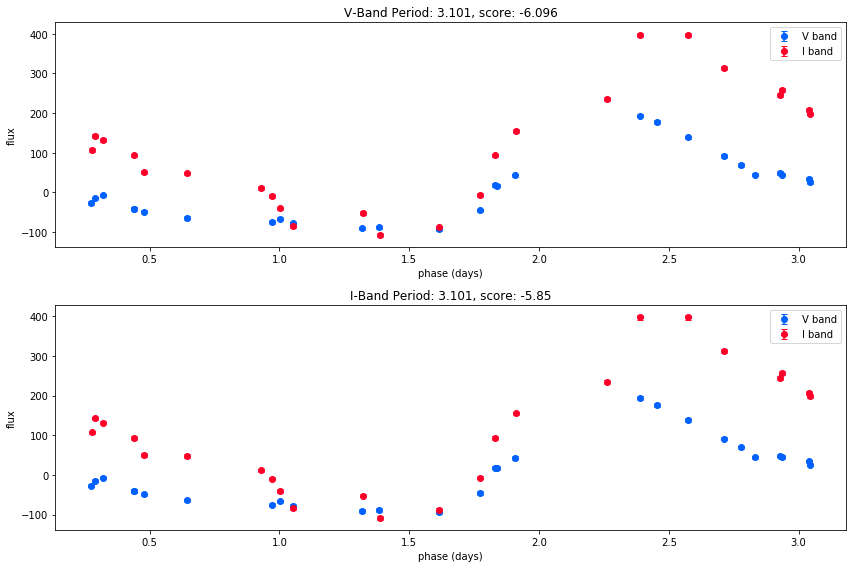

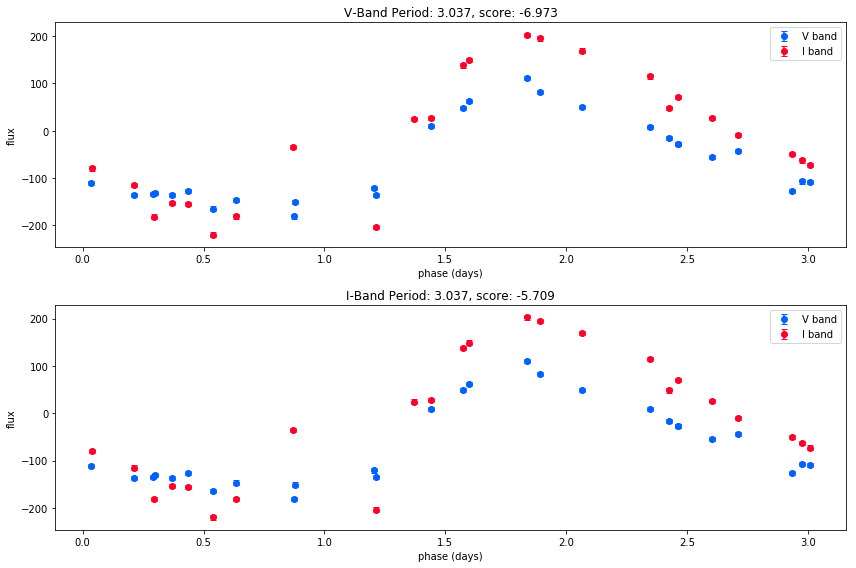

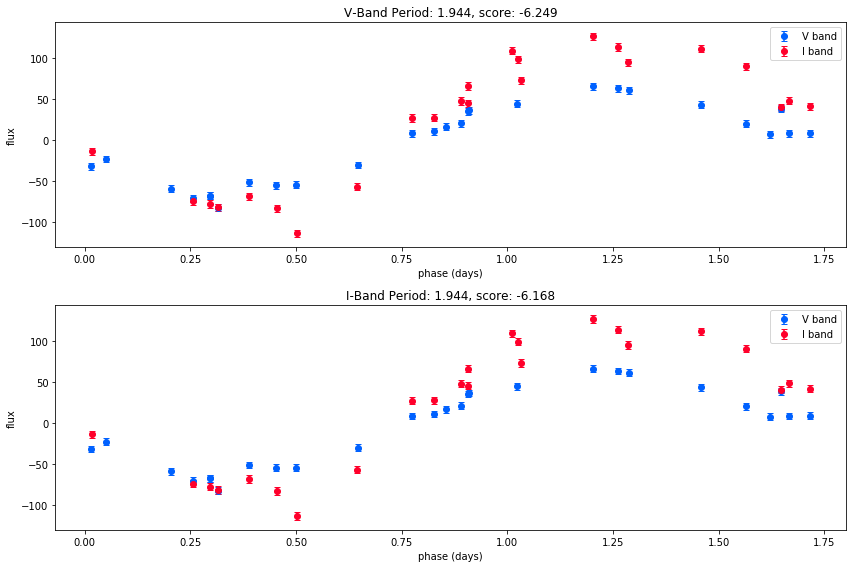

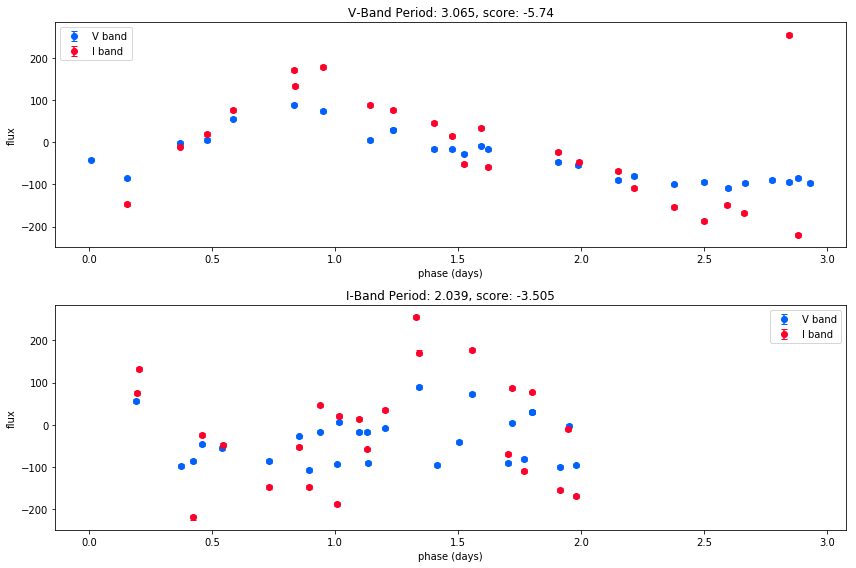

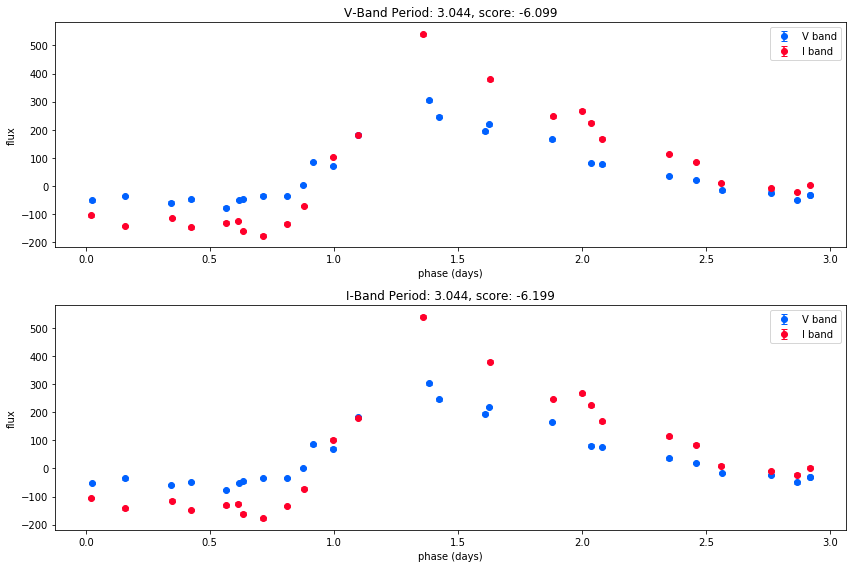

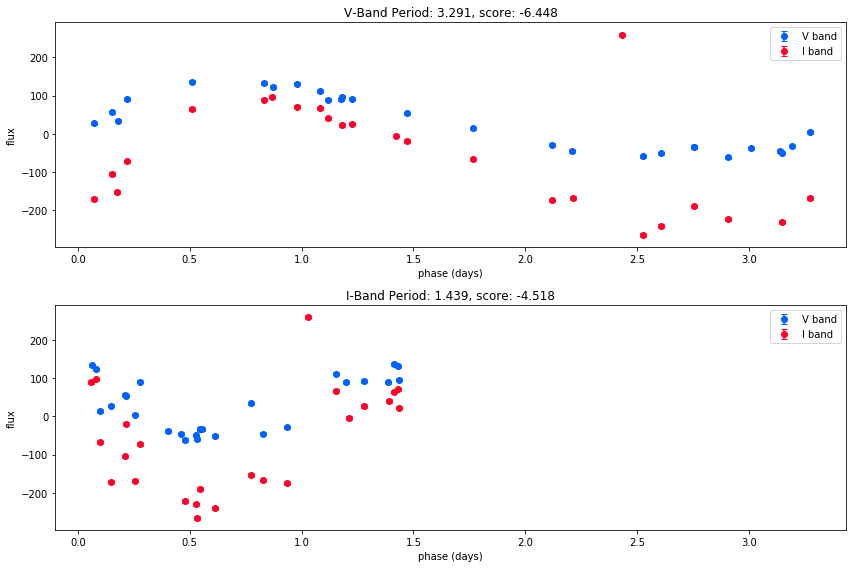

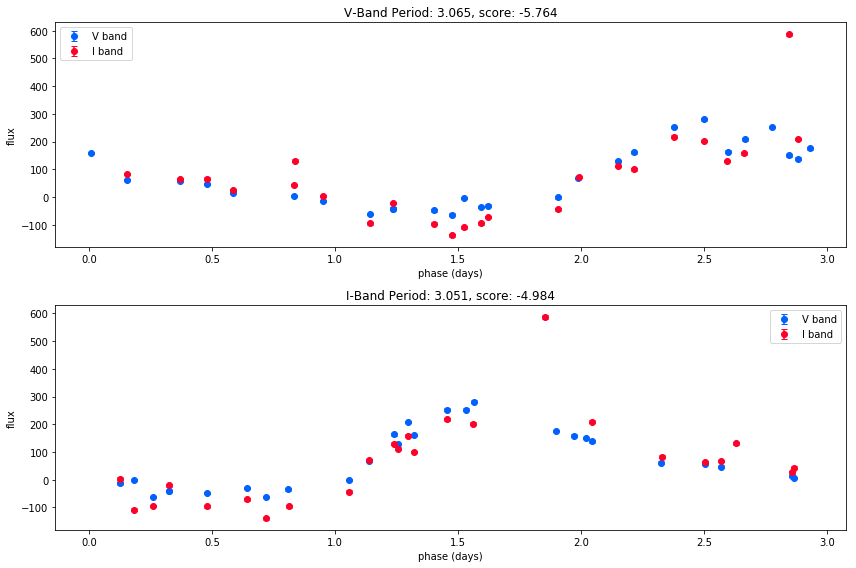

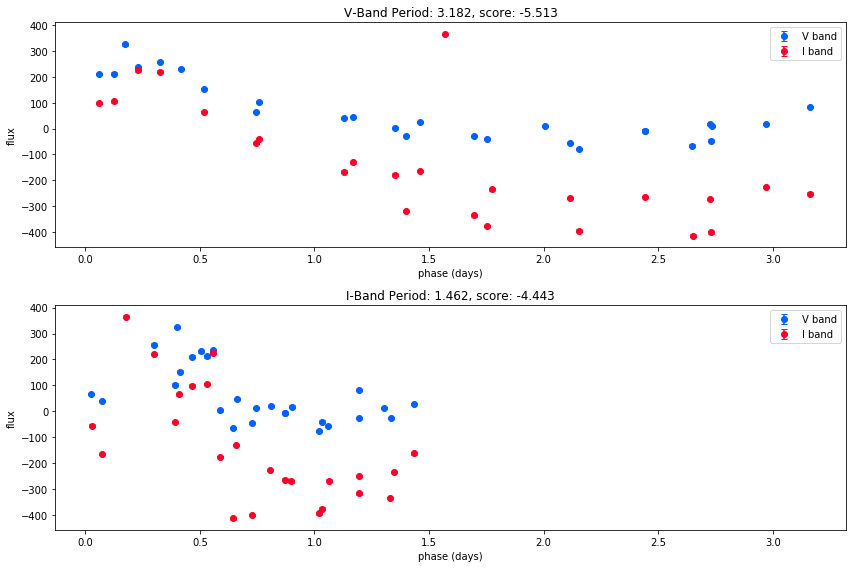

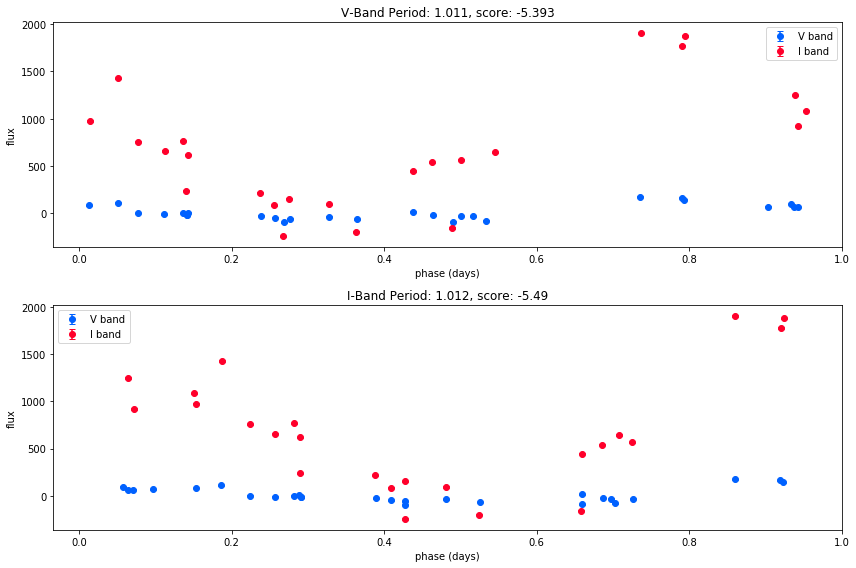

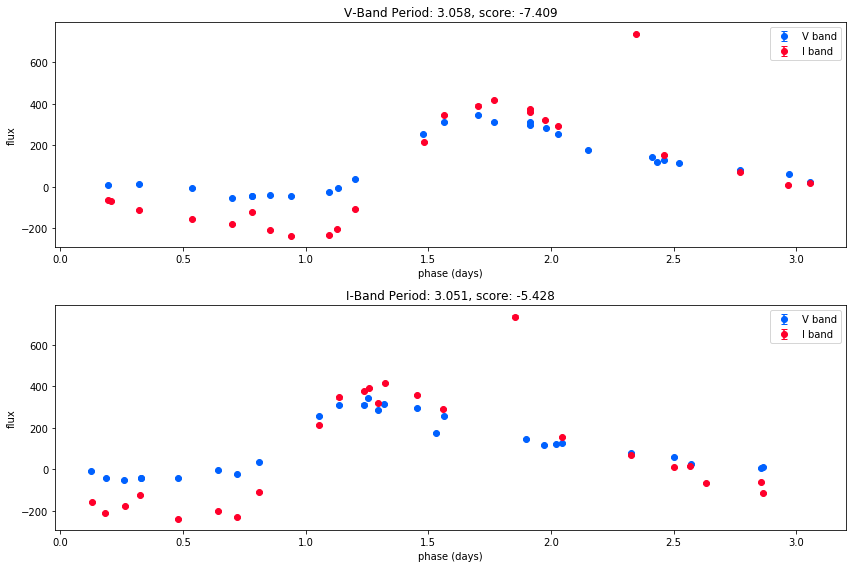

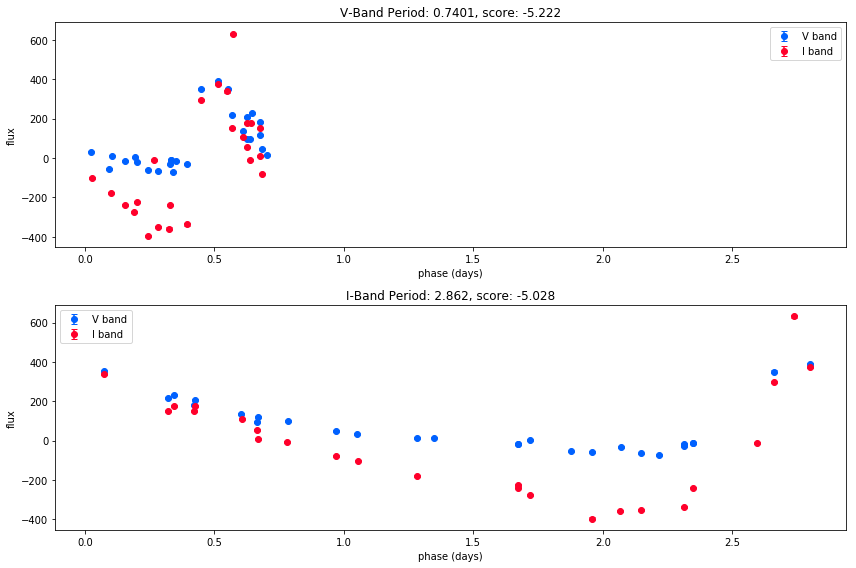

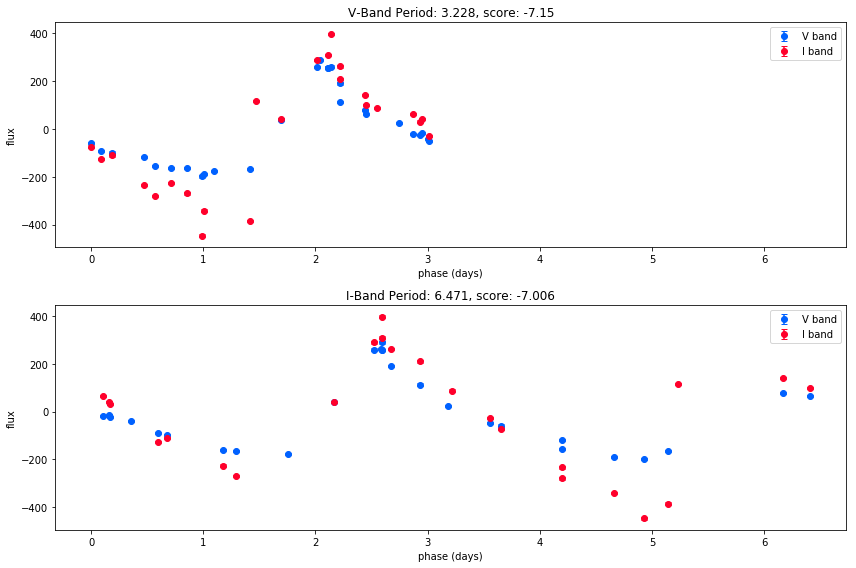

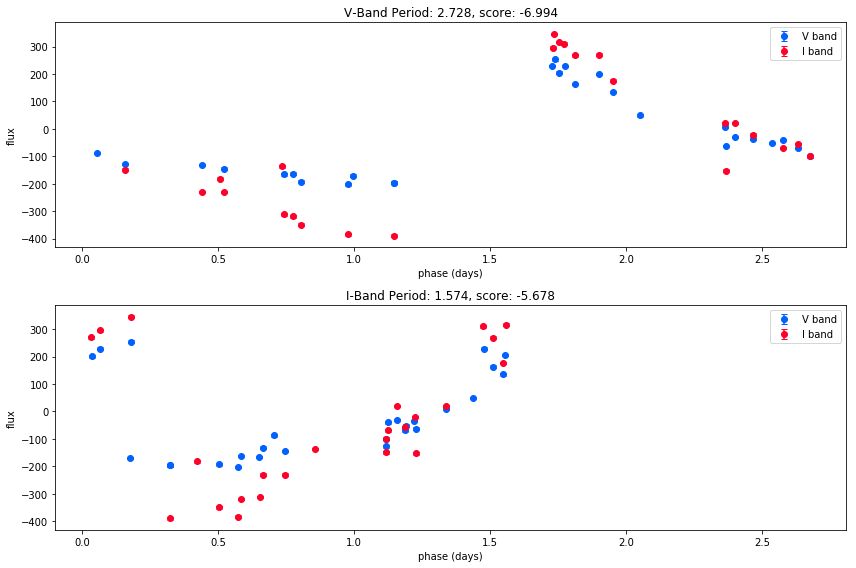

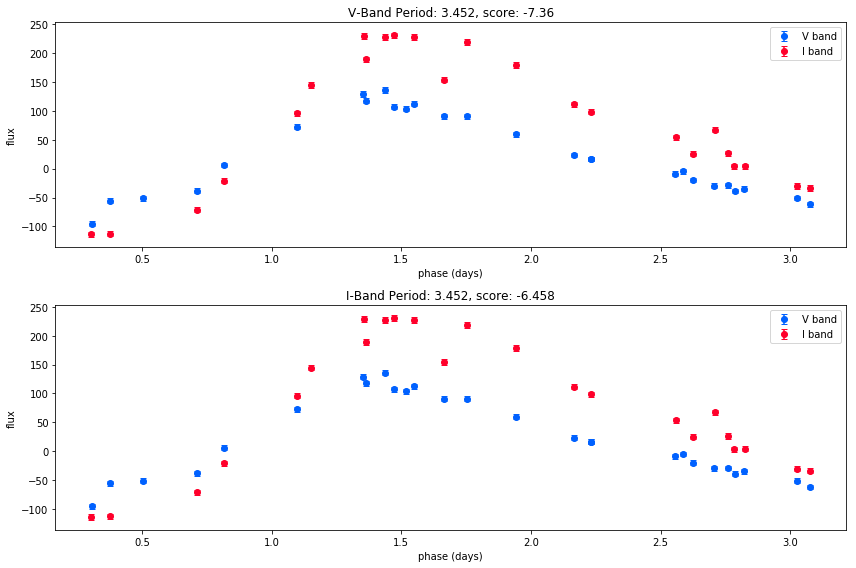

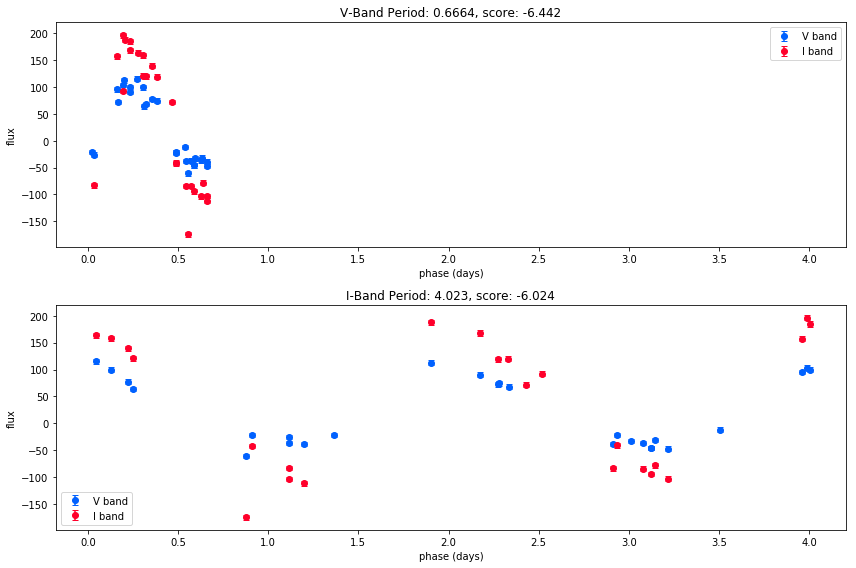

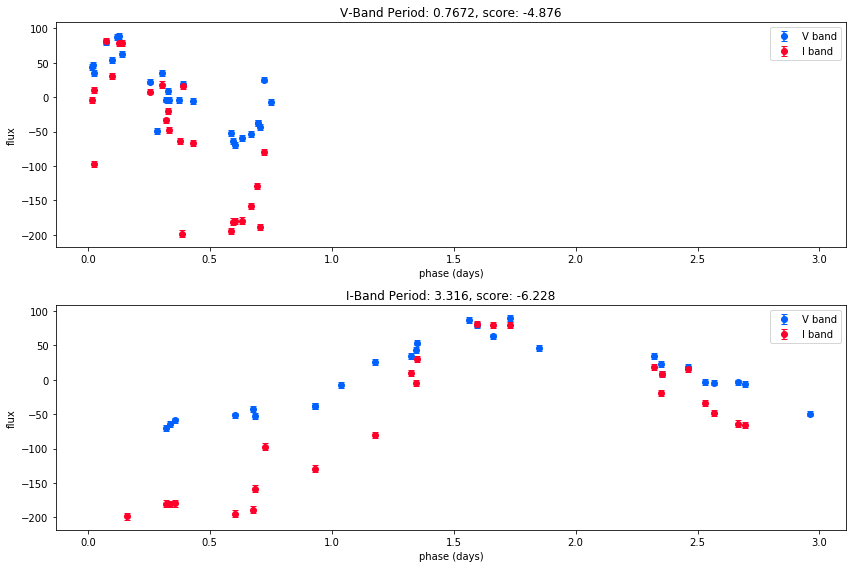

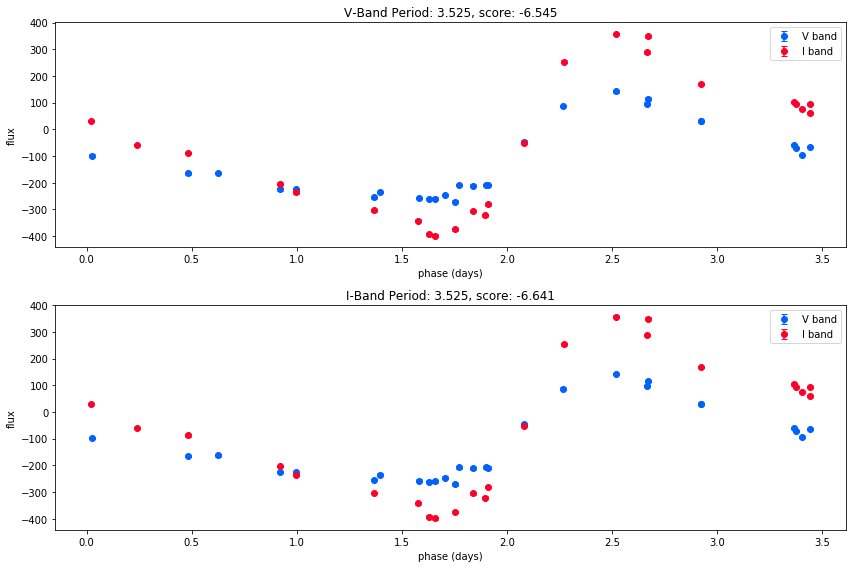

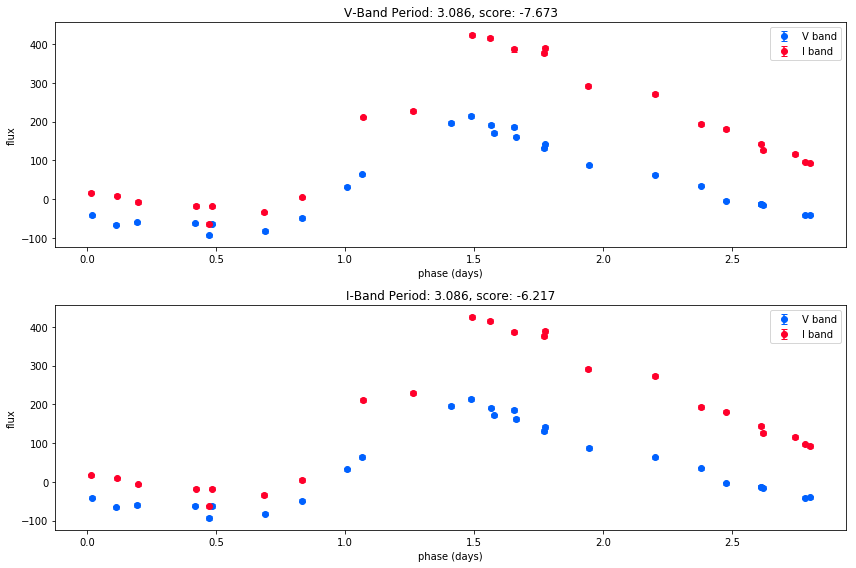

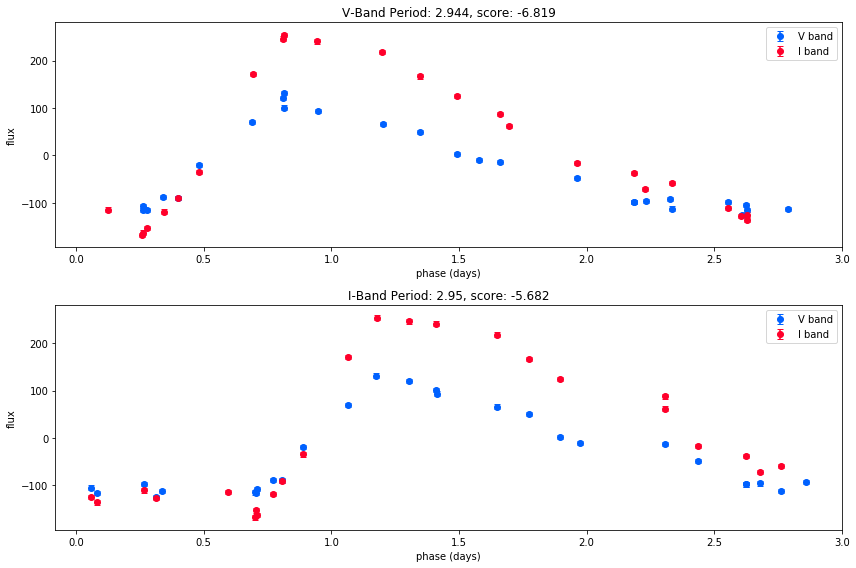

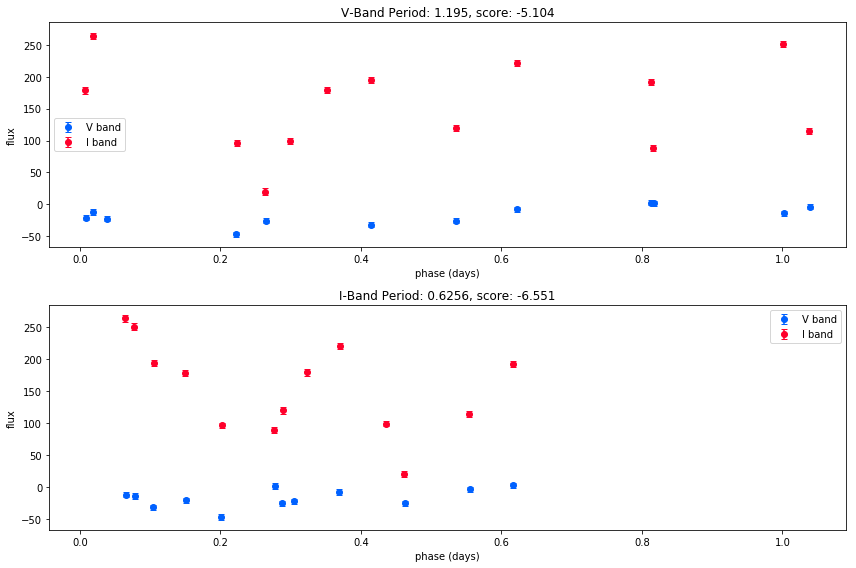

In [96]:
for star in full_crossmatch_table[mask]:
    plot_periodic(lc_table_v, lc_table_i, star, True)

In [113]:
full_crossmatch_table[mask]["period_best"].max()

51.51923076923077

## Making nice plots for the paper

### Saving some periodograms

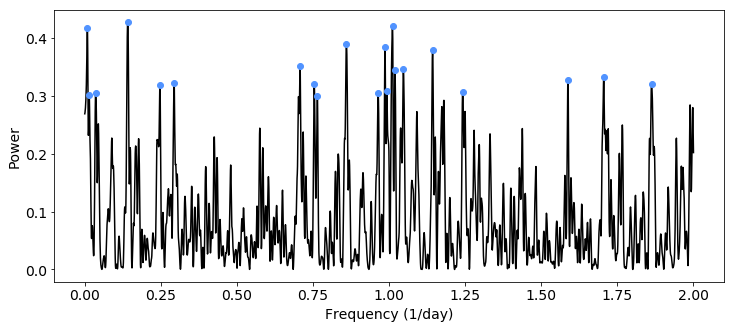

In [97]:
idx = 4
times = lc_table_v['date_obs']
mags = lc_table_v[f'mag_{idx}'] 
errs = lc_table_v[f'mag_err_{idx}']
    
# Getting rid of the nans
times = times[~np.isnan(mags)]
errs = errs[~np.isnan(mags)]
mags = mags[~np.isnan(mags)]
    

# Doing the periodogram
lomb = LombScargle(times,mags)
frequency = np.linspace(0,2,2680)
frequency = frequency[1:] # need to get rid of the literal 0 point
power = lomb.power(frequency)
    

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.plot(frequency, power, color='black')
ax1.set_xlabel("Frequency (1/day)", size=14)
ax1.set_ylabel("Power", size=14)
        
# Finding the peaks 
peak_inds, _ = find_peaks(power,height=0.3)

ax1.plot(frequency[peak_inds], power[peak_inds],'o', color='#5193ff')
    

#plt.savefig("../doc/plots/periodogram_aliasing.pdf")
        
plt.show()  
        

### Saving some phased LCs

In [108]:
def phase_plot(lc_table_v, lc_table_i, star_row, save=False, outfile=None):
    
    idx = star_row["id"]
    period = star_row["period_best"]
    
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(111)
    ax1.errorbar([period/4],[0],color='white',label=f"Period: {period:.3} days")
    ax1.errorbar(lc_table_v['date_obs']%period, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                 marker='>',linestyle='None',capsize=3,color='#2a61bb', ms=7, label=f"V band")
    ax1.errorbar(lc_table_i['date_obs']%period, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                 marker='o',linestyle='None',capsize=3, mec='#d71031', color='#d71031', mfc='white', mew=1.5,
                 ms=7, label=f"I band")
    
    #ax1.set_title(f"V-Band Period: {v_pd:.4}, score: {star_row['score_v']:.4}")
    ax1.set_xlabel("Phase (days)", fontsize=14)
    ax1.set_ylabel("Relative Flux (phot/sec)", fontsize=14)
    ax1.legend(fontsize=12)#, loc="lower left") 

    #ax1.set_ylim(-3000,3000)
    
    plt.tight_layout()
        
    if save:
        if not outfile:
            outfile = f"../doc/plots/phased_lc_{idx}.pdf"
        plt.savefig(outfile)
        
    plt.show()  
    

In [99]:
passing_variable_table = full_crossmatch_table[mask]

#### A really nice Cepheid LC

 id    period_best        score_best    
--- ----------------- ------------------
 13 3.443444730077121 -5.412104962432396


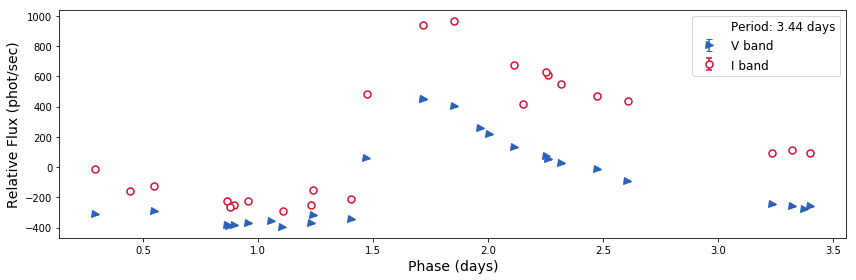

In [110]:
print(passing_variable_table["id", "period_best","score_best"][6])
phase_plot(lc_table_v, lc_table_i,passing_variable_table[6],save=True,outfile="../doc/plots/goodpd_lc.pdf")

#### The one with the 50 day period

 id    period_best        score_best    
--- ----------------- ------------------
  8 51.51923076923077 -5.710232706459219


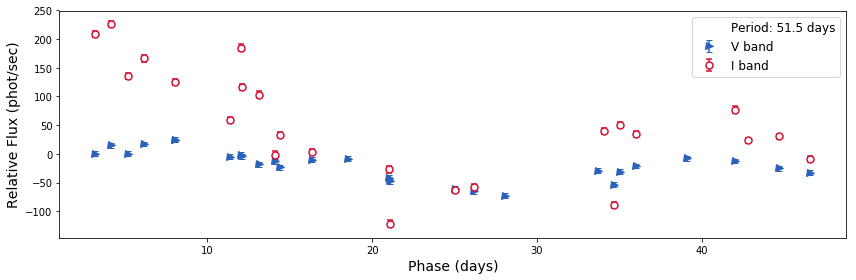

In [111]:
print(passing_variable_table["id", "period_best","score_best"][3])
phase_plot(lc_table_v, lc_table_i,passing_variable_table[3],save=True,outfile="../doc/plots/50daypd_lc.pdf")

#### An example of a bad one

 id    period_best          score_best    
--- ------------------ -------------------
  6 3.2045454545454546 -5.0092684565705605


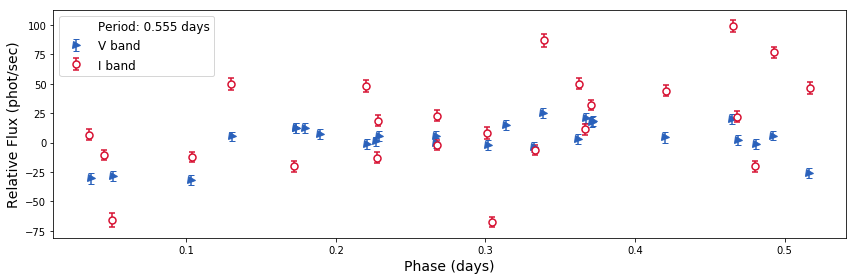

In [112]:
print(passing_variable_table["id", "period_best","score_best"][1])
phase_plot(lc_table_v, lc_table_i,full_crossmatch_table[~mask][1],save=True,outfile="../doc/plots/nonperiodic_lc.pdf")

#### The one in the OGLE database that didn't pass my threshold

 id    period_best         score_best    
--- ------------------ ------------------
 26 2.8930885529157666 -4.585780801422439


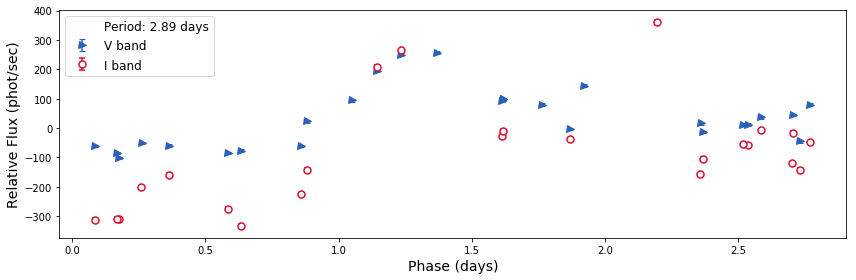

In [113]:
print(full_crossmatch_table["id", "period_best","score_best"][25])
phase_plot(lc_table_v, lc_table_i,full_crossmatch_table[25],save=False)

## Histogramming the periods

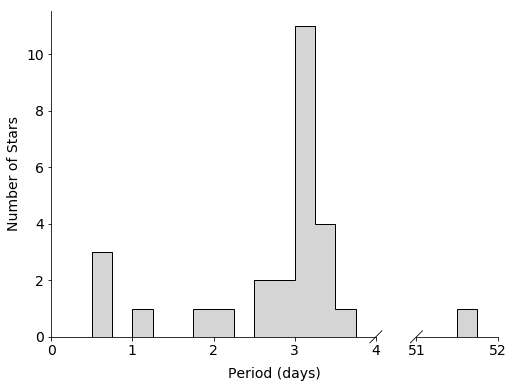

In [105]:
ig = plt.figure(figsize=(8,6))
fig.set_facecolor('w')
 
bins = np.linspace(0,52,52*4+1) 
bax = brokenaxes(xlims=((0, 4), (51, 52)))
bax.hist(passing_variable_table['period_best'], bins=bins, histtype='stepfilled', edgecolor='black', color='#d5d5d5')

bax.tick_params(axis='both', which='major', labelsize=14)

bax.set_xlabel("Period (days)", size=14)
bax.set_ylabel("Number of Stars", size=14)

fig.savefig("../doc/plots/period_histogram.pdf")

plt.show()